## To run this colab, press the "Runtime" button in the menu tab and then press the "Run all" button.

# Recognize Diseases using Transfer Learning

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
tf.__version__

'2.1.0'

## Setup Input Pipeline

Load the Sugarcane dataset.

In [0]:
base_dir='/content/drive/My Drive/Colab Notebooks/Dataset_sugarcane'


Use `ImageDataGenerator` to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

'''
train_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=base_dir,
                                                           shuffle=True,
                                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           class_mode='categorical')
val_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=base_dir,
                                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              class_mode='categorical')
'''



Found 950 images belonging to 4 classes.
Found 234 images belonging to 4 classes.


"\ntrain_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,\n                                                           directory=base_dir,\n                                                           shuffle=True,\n                                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),\n                                                           class_mode='categorical')\nval_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,\n                                                              directory=base_dir,\n                                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),\n                                                              class_mode='categorical')\n"

In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 4))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Save the labels in a file which will be downloaded later.

In [0]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'eye spot': 0, 'red rot': 1, 'wheat rust': 2, 'yellow leaf': 3}


In [0]:
!cat labels.txt

eye spot
red rot
wheat rust
yellow leaf

## Create the base model from the pre-trained convnets

Create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 10

history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 4 steps
Epoch 1/10
15/15 [==============================] - 503s 34s/step - loss: 1.8470 - accuracy: 0.4905 - val_loss: 0.9633 - val_accuracy: 0.6923
Epoch 2/10
15/15 [==============================] - 89s 6s/step - loss: 0.5453 - accuracy: 0.7926 - val_loss: 0.4692 - val_accuracy: 0.8248
Epoch 3/10
15/15 [==============================] - 89s 6s/step - loss: 0.2237 - accuracy: 0.9305 - val_loss: 0.3547 - val_accuracy: 0.8889
Epoch 4/10
15/15 [==============================] - 87s 6s/step - loss: 0.1015 - accuracy: 0.9779 - val_loss: 0.5505 - val_accuracy: 0.7949
Epoch 5/10
15/15 [==============================] - 88s 6s/step - loss: 0.0425 - accuracy: 0.9916 - val_loss: 0.5451 - val_accuracy: 0.8077
Epoch 6/10
15/15 [==============================] - 89s 6s/step - loss: 0.0243 - accuracy: 0.9968 - val_loss: 0.5308 - val_accuracy: 0.8419
Epoch 7/10
15/15 [==============================] - 88s 6s/step - l

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

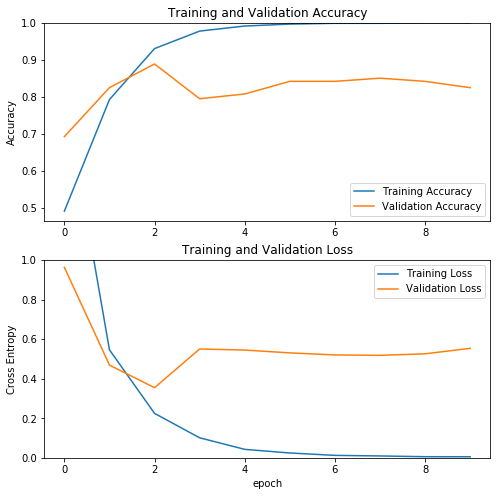

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 2,231,396
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


### Continue Train the model

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 4 steps
Epoch 1/5
15/15 [==============================] - 91s 6s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.5221 - val_accuracy: 0.8333
Epoch 2/5
15/15 [==============================] - 86s 6s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.8333
Epoch 3/5
15/15 [==============================] - 85s 6s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4629 - val_accuracy: 0.8675
Epoch 4/5
15/15 [==============================] - 88s 6s/step - loss: 9.3193e-04 - accuracy: 1.0000 - val_loss: 0.4494 - val_accuracy: 0.8718
Epoch 5/5
15/15 [==============================] - 87s 6s/step - loss: 6.8513e-04 - accuracy: 1.0000 - val_loss: 0.4404 - val_accuracy: 0.8718


## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [0]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


Download the converted model and labels

In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


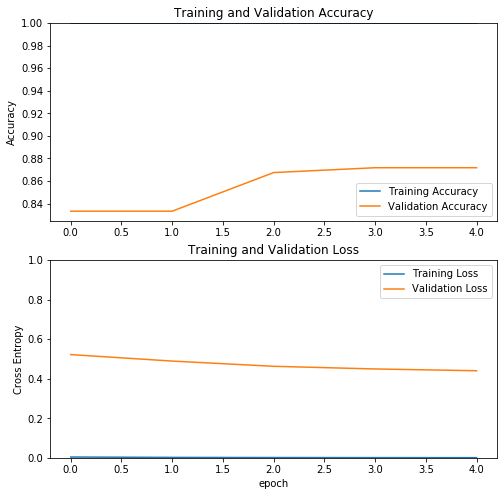

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.
